In [1]:
import time
import warnings
import gc
import copy
import math

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# Model selection and training
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb

# Metrics and evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, precision_recall_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, randint

# Start time
script_start_time = time.time()

# Add any additional functions or utility imports here
import shap

In [2]:
# Data Processing Functions
def summarize_dataframe(df):
    """
    Summarizes the structure and content of a DataFrame.
    """
    summary = {
        "Column": df.columns,
        "Non-Null Count": df.notnull().sum(),
        "Data Type": df.dtypes,
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing Values %": (df.isnull().sum() / len(df) * 100).round(2),
    }
    return pd.DataFrame(summary).reset_index(drop=True)
def chi_squared_test(data, target, bins=5):
    """
    Perform the Chi-Squared test for independence between all features
    and the target variable, handling both categorical and continuous features.

    Parameters:
        data (pd.DataFrame): The input dataset.
        target (str): The name of the target variable.
        bins (int): Number of bins to discretize continuous features. Default is 5.

    Returns:
        pd.DataFrame: A DataFrame containing features, their P-values, 
                      and whether they are significant.
    """
    # Separate target column
    target_data = data[target]
    features = data.drop(columns=[target], errors="ignore")

    # List to store results for each feature
    results = []

    for feature in features.columns:
        if features[feature].dtype in ['object', 'category']:
            # Categorical feature: Use directly
            feature_data = features[feature]
        else:
            # Continuous feature: Discretize into bins
            feature_data = pd.cut(features[feature], bins=bins, labels=False)

        # Create a contingency table for the current feature and target
        contingency_table = pd.crosstab(feature_data, target_data)

        # Perform the Chi-Squared test for independence
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Append the feature and p-value to the results list
        results.append({'Feature': feature, 'P-value': p, 'Significant': p < 0.05})

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)

    # Sort the results by P-value in ascending order
    sorted_results = results_df.sort_values(by='P-value', ascending=True)

    return sorted_results

# Model Evaluation Functions
def metrics_score(actual, predicted):
    """
    Calculates classification metrics and plots a confusion matrix.
    """
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="rainbow_r",
                xticklabels=["Not Defaulted", "Defaulted"],
                yticklabels=["Not Defaulted", "Defaulted"])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

In [3]:
survey_train_raw = pd.read_csv('../data/train/Surveydata_train_(2).csv')
survey_test_raw = pd.read_csv('../data/test/Surveydata_test_(2).csv')

In [4]:
travel_train_raw = pd.read_csv('../data/train/Traveldata_train_(2).csv')
travel_test_raw = pd.read_csv('../data/test/Traveldata_test_(2).csv')

In [5]:
train_raw = pd.merge(survey_train_raw, travel_train_raw, on='ID')
test_raw = pd.merge(survey_test_raw, travel_test_raw, on='ID')

In [6]:
travel_df = train_raw.copy()
travel_df_test = test_raw.copy()

In [7]:
travel_df.drop(columns='ID', inplace=True)

In [8]:
# Check for duplicates in training data and drop if found
num_duplicates = travel_df.duplicated().sum()  # Count duplicates

if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    travel_df.drop_duplicates(keep='first', inplace=True)  # Drop duplicates, keeping the first
    print(len(train_raw) - len(travel_df), "Duplicate rows dropped (keeping the first occurrence).")
    travel_df.reset_index(drop=True, inplace=True)  # Reset index after dropping duplicates
else:
    print("No duplicate rows found.")

Number of duplicate rows: 27
27 Duplicate rows dropped (keeping the first occurrence).


In [56]:
travel_df_imputed = travel_df.copy()
travel_df_test_imputed = travel_df_test.copy()

In [9]:
# # Identify categorical and numerical columns
# cat_cols = travel_df.select_dtypes(include=['object', 'category']).columns
# num_cols = travel_df.select_dtypes(exclude=['object', 'category']).columns

# # Encode categorical columns
# ordinal_encoder = OrdinalEncoder()
# travel_df[cat_cols] = ordinal_encoder.fit_transform(travel_df[cat_cols])

# # Apply KNN Imputer to the entire DataFrame
# imputer = KNNImputer(n_neighbors=5)
# travel_df_imputed = pd.DataFrame(imputer.fit_transform(travel_df), columns=travel_df.columns)

# # Handle categorical columns
# # Round categorical columns and convert to integers
# travel_df_imputed[cat_cols] = travel_df_imputed[cat_cols].round().astype(int)

# # Decode categorical columns back to original categories
# travel_df_imputed[cat_cols] = ordinal_encoder.inverse_transform(travel_df_imputed[cat_cols])

In [10]:
# # Identify categorical and numerical columns
# cat_cols_test = travel_df_test.select_dtypes(include=['object', 'category']).columns
# num_cols_test = travel_df_test.select_dtypes(exclude=['object', 'category']).columns

# # Encode categorical columns
# ordinal_encoder = OrdinalEncoder()
# travel_df_test[cat_cols_test] = ordinal_encoder.fit_transform(travel_df_test[cat_cols_test])

# # Apply KNN Imputer to the entire DataFrame
# imputer = KNNImputer(n_neighbors=5)
# travel_df_test_imputed = pd.DataFrame(imputer.fit_transform(travel_df_test), columns=travel_df_test.columns)

# # Handle categorical columns
# # Round categorical columns and convert to integers
# travel_df_test_imputed[cat_cols_test] = travel_df_test_imputed[cat_cols_test].round().astype(int)

In [11]:
# # Decode categorical columns back to original categories
# travel_df_test_imputed[cat_cols_test] = ordinal_encoder.inverse_transform(travel_df_test_imputed[cat_cols_test])

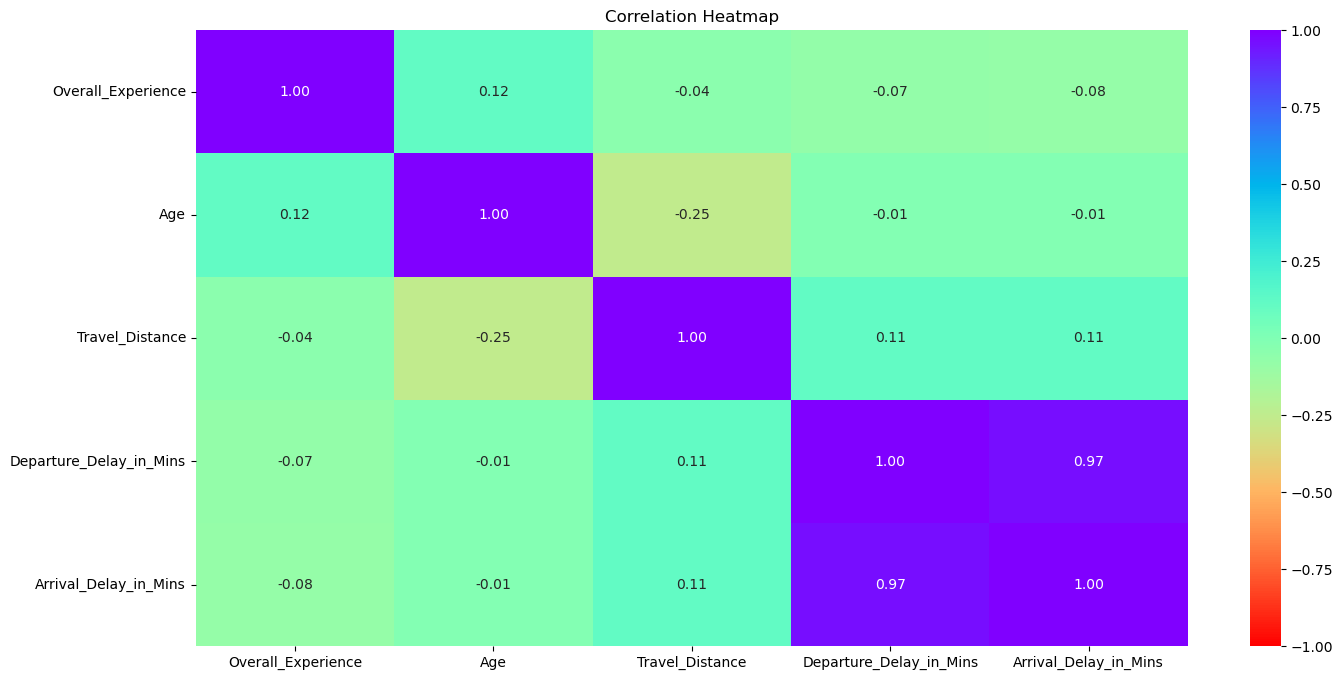

In [57]:
# Calculate the correlation matrix
correlation_matrix = travel_df_imputed[num_cols].corr()
# Plot the heatmap
plt.figure(figsize=(16, 8))  # Adjust figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow_r', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [58]:
travel_df_imputed['total_delay'] = travel_df_imputed['Departure_Delay_in_Mins'] + travel_df_imputed['Arrival_Delay_in_Mins']
travel_df_test_imputed['total_delay'] = travel_df_test_imputed['Departure_Delay_in_Mins'] + travel_df_test_imputed['Arrival_Delay_in_Mins']

In [59]:
travel_df_imputed.drop(columns=['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'], inplace=True)
travel_df_test_imputed.drop(columns=['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'], inplace=True)

In [60]:
# Perform the Chi-squared test to see if any of the features are not significant to predicting the target variable
print(chi_squared_test(travel_df_imputed, 'Overall_Experience'))

                    Feature        P-value  Significant
0              Seat_Comfort   0.000000e+00         True
19             Travel_Class   0.000000e+00         True
17                      Age   0.000000e+00         True
16            Customer_Type   0.000000e+00         True
15                   Gender   0.000000e+00         True
14          Online_Boarding   0.000000e+00         True
13              Cleanliness   0.000000e+00         True
12          CheckIn_Service   0.000000e+00         True
11         Baggage_Handling   0.000000e+00         True
20          Travel_Distance   0.000000e+00         True
10                  Legroom   0.000000e+00         True
8    Ease_of_Online_Booking   0.000000e+00         True
7            Online_Support   0.000000e+00         True
6     Onboard_Entertainment   0.000000e+00         True
5      Onboard_Wifi_Service   0.000000e+00         True
3                  Catering   0.000000e+00         True
9           Onboard_Service   0.000000e+00      

In [61]:
# travel_df_imputed.drop(columns='Seat_Class', inplace=True)
# travel_df_test_imputed.drop(columns='Seat_Class', inplace=True)

In [62]:
#Encoded column value replacement for ordinal categories
cols_to_replace = ['Seat_Comfort', 'Arrival_Time_Convenient', 'Catering', 'Onboard_Wifi_Service',
                   'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking',
                   'Onboard_Service','Legroom', 'CheckIn_Service',  'Cleanliness',
                   'Online_Boarding', 'Baggage_Handling']

# mapping dictionary
value_map = {'Excellent': 5, 'Good': 4, 'Acceptable': 3, 
            'Needs Improvement': 2, 'Poor': 1, 'Extremely Poor': 0}

# Update travel_df_imputed using lambda
for col in cols_to_replace:
    travel_df_imputed = travel_df_imputed.assign(**{
        col: travel_df_imputed[col].apply(lambda x: value_map.get(x, x)).infer_objects()
    })
    
# Update travel_df_test_imputed using lambda
for col in cols_to_replace:
    travel_df_test_imputed = travel_df_test_imputed.assign(**{
        col: travel_df_test_imputed[col].apply(lambda x: value_map.get(x, x)).infer_objects()
    })

In [63]:
# Mapping of old values to new values
value_map_p = {
    'Very Convenient': 5,
    'Needs Improvement': 2,
    'Manageable': 3,
    'Inconvenient': 1,
    'Convenient': 4,
    'Very Inconvenient': 0
}

# Replace values in the 'Satisfaction' column
travel_df_imputed['Platform_Location'] = (
    travel_df_imputed['Platform_Location']
    .map(value_map_p)
    .fillna(travel_df_imputed['Platform_Location'])  # Retain original values if not in value_map
    .infer_objects()  # Ensure correct dtype inference
)
travel_df_test_imputed['Platform_Location'] = (
    travel_df_test_imputed['Platform_Location']
    .map(value_map_p)
    .fillna(travel_df_test_imputed['Platform_Location'])  # Retain original values if not in value_map
    .infer_objects()  # Ensure correct dtype inference
)

travel_df_imputed['Platform_Location'] = travel_df_imputed['Platform_Location'].astype(int)
travel_df_test_imputed['Platform_Location'] = travel_df_test_imputed['Platform_Location'].astype(int)


# List of columns to be processed
columns = ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class']

# Define mapping for the remaining columns
mapping = {'Gender': {'female': 0, 'male': 1},
          'Customer_Type': {'loyal customer': 0, 'disloyal customer': 1}, 
          'Type_Travel': {'business travel': 0, 'personal travel': 1},
          'Travel_Class': {'business': 0, 'eco': 1}}

# Loop through columns and apply mappings in travel_df_imputed and travel_df_test_imputed
for col, mapping_dict in mapping.items():
    # Clean and standardize the column values before mapping
    travel_df_imputed[col] = (
        travel_df_imputed[col]
        .str.strip()  # Remove extra spaces
        .str.lower()  # Make lowercase for case-insensitive matching
        .map(lambda x: mapping_dict.get(x, x))  # Apply mapping
        .infer_objects()  # Ensure proper data type
    )
    
    travel_df_test_imputed[col] = (
        travel_df_test_imputed[col]
        .str.strip()
        .str.lower()
        .map(lambda x: mapping_dict.get(x, x))
        .infer_objects()
    )

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [19]:
# Function to bin Age column into intervals with labels
def bin_age(df, column, labels):
    df[column] = pd.cut(
        df[column],
        bins=5,  # Number of bins
        labels=labels,
        include_lowest=True  # Include the lowest value in the first interval
    )
    return df

# Bin edges will be calculated automatically, and labels are assigned
age_labels = ['25', '35', '45', '60', '80']

# Apply to both DataFrames
travel_df_imputed = bin_age(travel_df_imputed, 'Age', age_labels)
travel_df_test_imputed = bin_age(travel_df_test_imputed, 'Age', age_labels)

In [20]:
travel_df_imputed = pd.get_dummies(travel_df_imputed)
travel_df_test_imputed = pd.get_dummies(travel_df_test_imputed)

In [21]:
travel_df_imputed['Overall_Experience'].value_counts(normalize=True)

Overall_Experience
1.0    0.546687
0.0    0.453313
Name: proportion, dtype: float64

In [22]:
#seperating the independant and dependant variables
X = travel_df_imputed.drop('Overall_Experience', axis = 1)
Y = travel_df_imputed['Overall_Experience']

X_test = travel_df_test_imputed.copy()

In [23]:
summarize_dataframe(X_test)

,Column,Non-Null Count,Data Type,Unique Values,Missing Values,Missing Values %
0,ID,35602,float64,35602,0,0.0
1,Seat_Comfort,35602,int64,6,0,0.0
2,Arrival_Time_Convenient,35602,int64,6,0,0.0
3,Catering,35602,int64,6,0,0.0
4,Platform_Location,35602,int64,5,0,0.0
5,Onboard_Wifi_Service,35602,int64,6,0,0.0
6,Onboard_Entertainment,35602,int64,6,0,0.0
7,Online_Support,35602,int64,5,0,0.0
8,Ease_of_Online_Booking,35602,int64,6,0,0.0
9,Onboard_Service,35602,int64,5,0,0.0


In [24]:
# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

X_test_scaled = sc.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [25]:
# Create the training anb testing datasets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size = 0.3, random_state = 1, stratify = Y)
# Reset index of test set for alignment
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
# Fitting the Random Forest classifier on the training data
rf = RandomForestClassifier(criterion='entropy', random_state=1)

rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=1)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29940
         1.0       1.00      1.00      1.00     36106

    accuracy                           1.00     66046
   macro avg       1.00      1.00      1.00     66046
weighted avg       1.00      1.00      1.00     66046



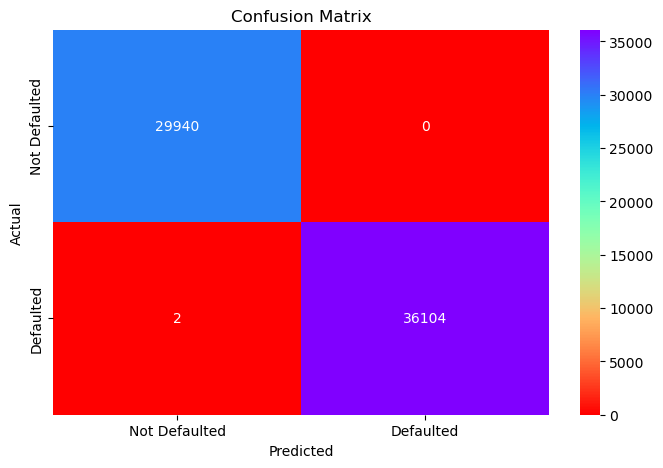

In [27]:
# Checking performance on the training data
y_pred_train_rf = rf.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     12831
         1.0       0.96      0.95      0.95     15475

    accuracy                           0.95     28306
   macro avg       0.95      0.95      0.95     28306
weighted avg       0.95      0.95      0.95     28306



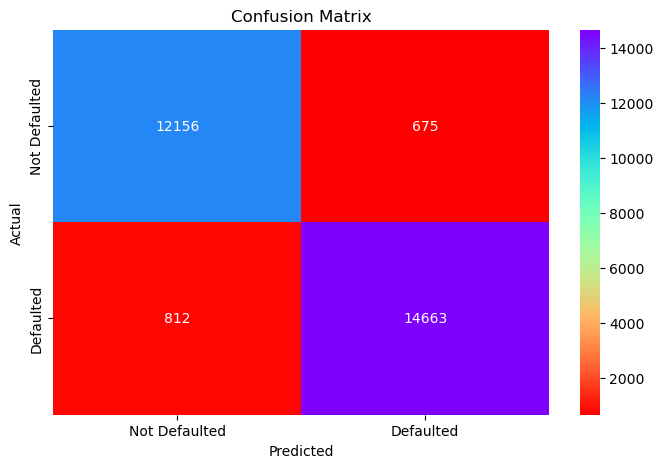

In [28]:
# Checking performance on the training data
y_pred_test_rf = rf.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [29]:
# Define the model
rf_estimator = RandomForestClassifier(
    bootstrap=False,
    criterion='gini',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300,
    random_state=1,
    n_jobs=-1
)
rf_estimator.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=300,
                       n_jobs=-1, random_state=1)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29940
         1.0       1.00      1.00      1.00     36106

    accuracy                           1.00     66046
   macro avg       1.00      1.00      1.00     66046
weighted avg       1.00      1.00      1.00     66046



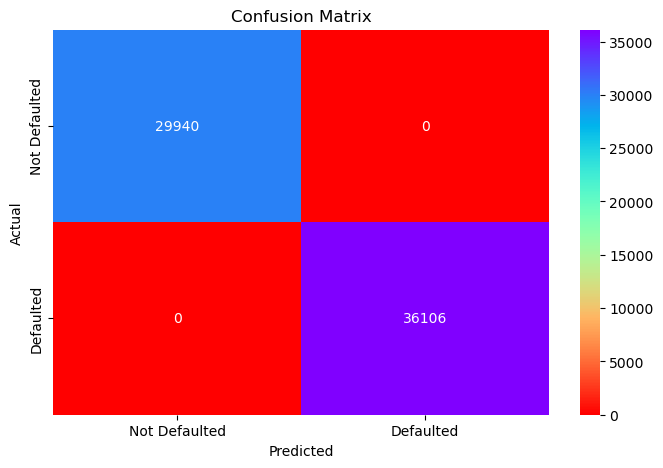

In [30]:
# Checking performance on the training data
y_pred_train_rfe = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rfe)

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94     12831
         1.0       0.96      0.95      0.95     15475

    accuracy                           0.95     28306
   macro avg       0.95      0.95      0.95     28306
weighted avg       0.95      0.95      0.95     28306



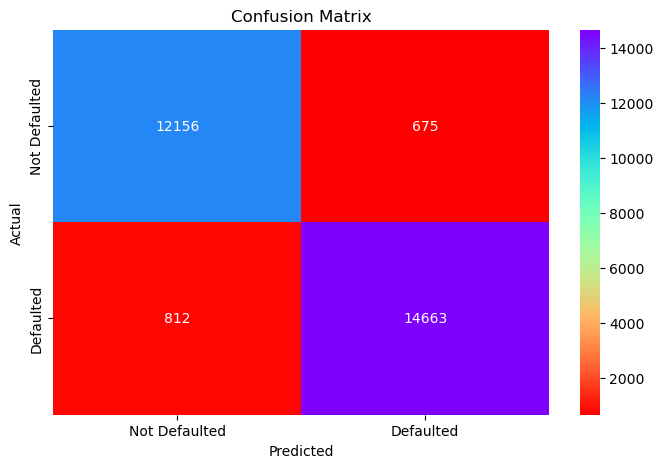

In [31]:
# Checking performance on the training data
y_pred_test_rfe = rf.predict(x_test)

metrics_score(y_test, y_pred_test_rfe)

In [32]:
# # Define the Random Forest model
# rf_estimator_grid = RandomForestClassifier(random_state=1)

# # Define parameter distributions for random search
# param_distributions = {
#     'criterion': ['gini'],  # Fixed
#     'n_estimators': randint(100, 500),  # Range 100-500
#     'max_depth': [10, 20],  # Fixed
#     'min_samples_split': randint(2, 10),  # Range 2-10
#     'min_samples_leaf': randint(1, 5),  # Range 1-5
#     'max_features': ['sqrt', 'log2'],  # Fixed
#     'bootstrap': [True]  # Fixed
# }

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=rf_estimator_grid,
#     param_distributions=param_distributions,
#     n_iter=50,  # Number of random combinations to test?
#     scoring='accuracy',
#     cv=5,
#     n_jobs=-1,
#     verbose=1,
#     random_state=1
# )

# # Perform the search on the training data
# random_search.fit(x_train, y_train)

# # Store best parameters and cross-validation score
# results = {
#     'best_params': random_search.best_params_,
#     'best_score': random_search.best_score_,
#     'best_model': random_search.best_estimator_
# }

# # Print results
# print("Best Parameters:", results['best_params'])
# print("Best Cross-Validated Accuracy:", results['best_score'])
# print("Best Model:", results['best_model'])

In [33]:
# # Checking performance on the training data
# y_pred_test_rs = results['best_model'].predict(x_test)

# metrics_score(y_test, y_pred_test_rs)

In [34]:
# ada = AdaBoostClassifier(estimator=results['best_model'], n_estimators=50, learning_rate=0.1, random_state=88)
# ada.fit(x_train, y_train)

In [35]:
# # Checking performance on the training data
# y_pred_train_ada = ada.predict(x_train)

# metrics_score(y_train, y_pred_train_ada)

In [36]:
# # Checking performance on the training data
# y_pred_test_ada = ada.predict(x_test)

# metrics_score(y_test, y_pred_test_ada)

In [37]:
# # create output csv file with predictions for each customer
# ada_test = travel_df_test_imputed.copy()

# X_test_scaled.drop('ID', axis=1, inplace=True)
# # Make predictions
# predictions = ada.predict(X_test_scaled)

# # Add predictions back to the dataset
# ada_test['Overall_Experience'] = predictions

In [38]:
# # Create the final submission file
# final_predictions = ada_test[['ID', 'Overall_Experience']]
# final_predictions.to_csv('../data/customer_pred7.csv', index=False)

In [39]:
# # Initialize the XGBoost Classifier with a Random Forest estimator
# xgb_rf = xgb.XGBRFClassifier(
#     objective='binary:logistic',  # Binary classification
#     random_state=1,              # Set a random state for reproducibility
#     n_estimators=100,            # Number of trees
#     max_depth=6,                 # Maximum depth of a tree
#     learning_rate=0.9,           # Learning rate
#     subsample=0.8,               # Subsample ratio for rows
#     colsample_bynode=0.8,        # Subsample ratio for columns per node
#     eval_metric='logloss'        # Evaluation metric
# )

# # Train the model
# xgb_rf.fit(x_train, y_train)

# # Predict on the test set
# y_pred_xgb = xgb_rf.predict(x_test)

# # Evaluate the performance
# print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
# print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

In [40]:
# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bynode': [0.6, 0.8, 1.0]
# }

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=xgb.XGBRFClassifier(objective='binary:logistic', random_state=1),
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='accuracy',
#     cv=5,
#     verbose=1,
#     random_state=1,
#     n_jobs=-1
# )

# # Perform the search
# random_search.fit(x_train, y_train)

# # Best model
# best_model = random_search.best_estimator_

# # Evaluate the tuned model
# y_pred_xgb1 = best_model.predict(x_test)
# print("Tuned Accuracy:", accuracy_score(y_test, y_pred_xgb1))
# print("Classification Report:\n", classification_report(y_test, y_pred_xgb1))

In [50]:
class RFBoost:
    def __init__(self, n_estimators=10, rf_params=None, learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.rf_params = rf_params if rf_params else {}
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples  # Initialize sample weights
        
        for i in range(self.n_estimators):
            # Train a Random Forest on the weighted dataset
            rf = RandomForestClassifier(**self.rf_params, random_state=i)
            rf.fit(X, y, sample_weight=sample_weights)
            predictions = rf.predict(X)
            
            # Compute misclassification errors
            incorrect = (predictions != y)
            error = np.dot(sample_weights, incorrect) / sum(sample_weights)
            
            # Stop if error is zero
            if error == 0:
                self.models.append(rf)
                self.model_weights.append(1.0)
                break

            # Compute model weight
            model_weight = self.learning_rate * np.log((1 - error) / error)
            self.models.append(rf)
            self.model_weights.append(model_weight)
            
            # Update sample weights
            sample_weights *= np.exp(model_weight * incorrect)
            sample_weights /= sum(sample_weights)  # Normalize weights
    
    def predict(self, X):
        # Weighted majority vote
        model_preds = np.array([model.predict(X) for model in self.models])
        weighted_preds = np.tensordot(self.model_weights, model_preds, axes=(0, 0))
        return (weighted_preds >= 0.5).astype(int)  # Convert to binary predictions

    def predict_proba(self, X):
        # Weighted probabilities
        model_probas = np.array([model.predict_proba(X) for model in self.models])
        weighted_probas = np.tensordot(self.model_weights, model_probas, axes=(0, 0))
        return weighted_probas / sum(self.model_weights)

# Example usage
rf_params = {
    'bootstrap': False,
    'criterion': 'gini',
    'max_depth': None,
    'max_features':10,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_jobs': -1
}

# Initialize RFBoost
rfboost = RFBoost(n_estimators=500, rf_params=rf_params, learning_rate=0.1)

# Fit the model
rfboost.fit(x_train, y_train)

# Make predictions
y_pred_rfb = rfboost.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rfb))

Accuracy: 0.9513530700204904


In [52]:
# create output csv file with predictions for each customer
ada_test = travel_df_test_imputed.copy()

# X_test_scaled.drop('ID', axis=1, inplace=True)
# Make predictions
predictions = rfboost.predict(X_test_scaled)

# Add predictions back to the dataset
ada_test['Overall_Experience'] = predictions

In [53]:
ada_test['ID'] = ada_test['ID'].astype(int)

In [54]:
# ada_test['Overall_Experience'].value_counts(normalize=True)

In [55]:
# Create the final submission file
final_predictions = ada_test[['ID', 'Overall_Experience']]
final_predictions.to_csv('../data/customer_pred9.csv', index=False)

In [68]:
class RFBoost:
    def __init__(self, n_estimators=10, learning_rate=1.0, rf_params=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

        # Convert rf_params to frozenset for immutability
        self.rf_params = frozenset(rf_params.items()) if rf_params else frozenset()

        # Internal attributes for training
        self.models = []
        self.model_weights = []

    def fit(self, X, y, sample_weight=None):
        self.models = []  # Reset models
        self.model_weights = []  # Reset weights

        # Initialize sample weights
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples

        rf_params_dict = dict(self.rf_params)  # Convert back to dictionary for use
        for i in range(self.n_estimators):
            # Train Random Forest with current sample weights
            rf = RandomForestClassifier(**rf_params_dict, random_state=i)
            rf.fit(X, y, sample_weight=sample_weights)
            predictions = rf.predict(X)

            # Compute misclassification error
            incorrect = (predictions != y)
            error = np.dot(sample_weights, incorrect) / sum(sample_weights)

            # Stop if error is 0
            if error == 0:
                self.models.append(rf)
                self.model_weights.append(1.0)
                break

            # Compute model weight
            model_weight = self.learning_rate * np.log((1 - error) / error)
            self.models.append(rf)
            self.model_weights.append(model_weight)

            # Update sample weights
            sample_weights *= np.exp(model_weight * incorrect)
            sample_weights /= sum(sample_weights)  # Normalize

    def predict(self, X):
        # Weighted majority vote
        model_preds = np.array([model.predict(X) for model in self.models])
        weighted_preds = np.tensordot(self.model_weights, model_preds, axes=(0, 0))
        return (weighted_preds >= 0.5).astype(int)  # Convert to binary predictions

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        # Return hyperparameters, ensuring rf_params is immutable
        return {
            'n_estimators': self.n_estimators,
            'learning_rate': self.learning_rate,
            'rf_params': self.rf_params
        }

    def set_params(self, **params):
        # Set parameters, ensuring rf_params is immutable
        for key, value in params.items():
            if key == 'rf_params' and value is not None:
                self.rf_params = frozenset(value.items())  # Convert to frozenset
            else:
                setattr(self, key, value)
        return self

In [73]:
# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [220],  # Number of boosting rounds
    'learning_rate': [0.0001],  # Learning rate for boosting
    'rf_params': [
        {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features':10,},  # RF params
        # {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features':10,}
    ]
}

# Wrap RFBoost in GridSearchCV
rfboost = RFBoost()
grid_search = GridSearchCV(
    estimator=rfboost,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 3-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Perform GridSearchCV
grid_search.fit(x_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model for predictions
best_rfboost = grid_search.best_estimator_
y_pred = best_rfboost.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'learning_rate': 0.0001, 'n_estimators': 220, 'rf_params': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 10}}
Best Cross-Validation Accuracy: 0.8483768831713793
Test Accuracy: 0.9488447678937327


In [75]:
# create output csv file with predictions for each customer
ada_test = travel_df_test_imputed.copy()

# X_test_scaled.drop('ID', axis=1, inplace=True)
# Make predictions
predictions = best_rfboost.predict(X_test_scaled)

# Add predictions back to the dataset
ada_test['Overall_Experience'] = predictions

ada_test['ID'] = ada_test['ID'].astype(int)

# Create the final submission file
final_predictions = ada_test[['ID', 'Overall_Experience']]
final_predictions.to_csv('../data/customer_pred11.csv', index=False)

In [40]:
gc.collect()

5622

In [41]:
script_end_time = time.time()

In [42]:
print('Total Exec time', script_end_time - script_start_time)

Total Exec time 1231.3318762779236
